<a href="https://colab.research.google.com/github/RakeshReddyKondeti/Robotics_UniversityofLuebeck/blob/master/ComputerVision_Exercise_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SS 2021
## Exercise Sheet 3: Image Center, Edges, Keypoints
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. Rakes Reddy Kondeti
2. Christopher Schmale
3. Tim-Henrik Traving
4. 
5. 


In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation

%matplotlib inline

## Exercise 3.1
### Finding the Image Center
Camera calibration refers to the process of computing the intrinsic and extrinsic parameters of the camera. It is a necessary step in many computer vision applications such as 3D scene reconstruction and recognition. One important intrinsic parameter is the image center. Print out the images `ueb311.jpg` and `ueb312.jpg` and estimate the image centers by using a ruler.

**Hint**: Make small printouts of the images to have enough space around them.

In [ ]:
def load_image_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
def load_image_gray_normalized(image_path):
    return load_image_gray(image_path).astype('float32')/255.

In [ ]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y


## Exercise 3.2.1
### Edge Detection
Open the image `ueb32.jpg` in Python and show the image gradients $d_x$ and $d_y$. Compute the magnitude of gradients image and apply a threshold to retain only the edges of the object. For those edges, compute and show the gradient angle image (`np.arctan2`). How can you tell the angle of the gradient from looking only at the gradients?

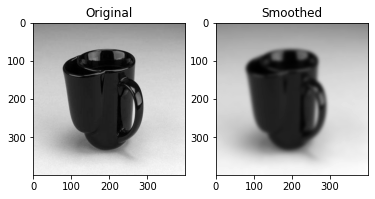

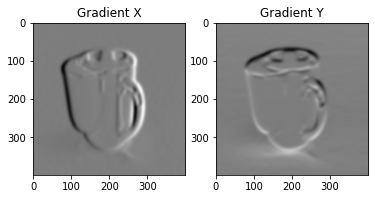

-177.87889


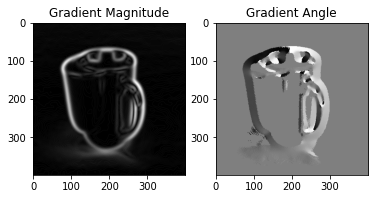

In [ ]:
# load image
image = load_image_gray("./data/exercise_3/ueb32.jpg")

# smooth image
plt.subplot(1,2,1), plt.imshow(image, cmap="gray"), plt.title("Original")
image = cv2.GaussianBlur(image, (25,25), cv2.BORDER_DEFAULT)
plt.subplot(1,2,2), plt.imshow(image, cmap="gray"), plt.title("Smoothed")
plt.show()

# compute and show gradient images 
gradient_x, gradient_y = gradient(image)

minvalue = min(gradient_x.min(), gradient_x.min())
maxvalue = max(gradient_x.max(), gradient_x.max())
plt.subplot(1,2,1), plt.imshow(gradient_x, cmap="gray", vmin=minvalue, vmax=maxvalue), plt.title("Gradient X")
plt.subplot(1,2,2), plt.imshow(gradient_y, cmap="gray", vmin=minvalue, vmax=maxvalue), plt.title("Gradient Y")
plt.show()

# make images comparable

# compute gradient magnitude
gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

plt.subplot(1,2,1), plt.imshow(gradient_magnitude, cmap="gray"), plt.title("Gradient Magnitude")

# compute an angle image that should be in range [-180,+180]
angle_image = np.rad2deg(np.arctan2(gradient_x, gradient_y))

mask = gradient_magnitude > 1.5
mask = mask.astype("float")

angle_image = angle_image * mask

# show angles only for real edges
plt.subplot(1,2,2), plt.imshow(angle_image, cmap="gray"), plt.title("Gradient Angle")
plt.show()

## Exercise 3.2.2
### Canny Edge Detector
Open the image `ueb32.jpg` in Python and use the OpenCV Canny algorithm to find the edges in the image.
Compare the result with the magnitude of gradient image. Ddisplay both results side by side using `plt.subplots`.
Comment on how the two results differ and why.

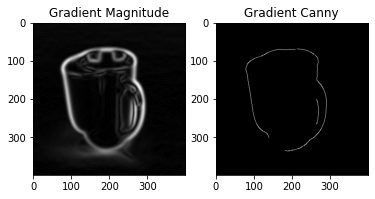

In [ ]:
# load image
#image = load_image_gray("./data/exercise_3/ueb32.jpg")

# compute magnitude of gradient image
#gradient_x, gradient_x = gradient(image)
#gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

# apply canny
gradient_canny = cv2.Canny(image, 10, 100) #<---------------------------------------- Find correct Thresholds

# compare results
plt.subplot(1,2,1), plt.imshow(gradient_magnitude, cmap="gray"), plt.title("Gradient Magnitude")
plt.subplot(1,2,2), plt.imshow(gradient_canny, cmap="gray"), plt.title("Gradient Canny")
plt.show()

## Exercise 3.3
### Key Point Detection
Implement the following key-point detectors:
* local maxima of $K$
* local maxima of $K$ − $\alpha$ $H^2$, with $\alpha$ as weighting parameter

The function is supposed to return images of the same size as the input, where the pixels contain $K$ or $K$ − $\alpha$ $H^2$.

$K$ and $H$ should be the invariants of the structure tensor $J$ (see script).
Evaluate the detectors above on two kinds of test images: (i) the synthetic image `ueb331.npy`, (ii) the
picture `ueb332.jpg`.

Comment your results with a focus on
1. the localization of the key points
2. the influence of the $H$ term as controlled via the parameter $\alpha$.

**Question**: Why do you filter the image with a Gaussian kernel? It is **not** about noise removal!

**Hint**: Use the provided functions `find_local_max` and `plot_marks`.

In [ ]:
def find_local_max(keypoints, thres=1e-6):
    kernel = np.ones((3, 3))
    kernel[1, 1] = 0
    local_max = keypoints > thres + dilation(keypoints, kernel)

    return local_max

In [ ]:
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)

    ax.plot(row, col, 'r.')

In [ ]:
def key_points_structure(image, alpha):
    # image parameters
    kernalsize = 25
    kernel = np.array([-1, 1])


    # 1. partial derivatives
    gradient_x, gradient_y = gradient(image)

    # 2. product images
    gradient_x_sq = np.multiply(gradient_x, gradient_x)
    gradient_y_sq = np.multiply(gradient_y, gradient_y)
    gradient_x_y = np.multiply(gradient_x, gradient_y)


    # 3. filter with gaussian kernel
    J = cv2.GaussianBlur(image, (kernalsize,kernalsize), cv2.BORDER_DEFAULT)

    # 4. compute invarians for J
    H = gradient_x_sq + gradient_y_sq

    K = np.multiply(gradient_x_sq,gradient_y_sq) - np.multiply(gradient_x_y, gradient_x_y)
    K_minus_H = K - alpha * np.multiply(H, H)

    return K, K_minus_H
    

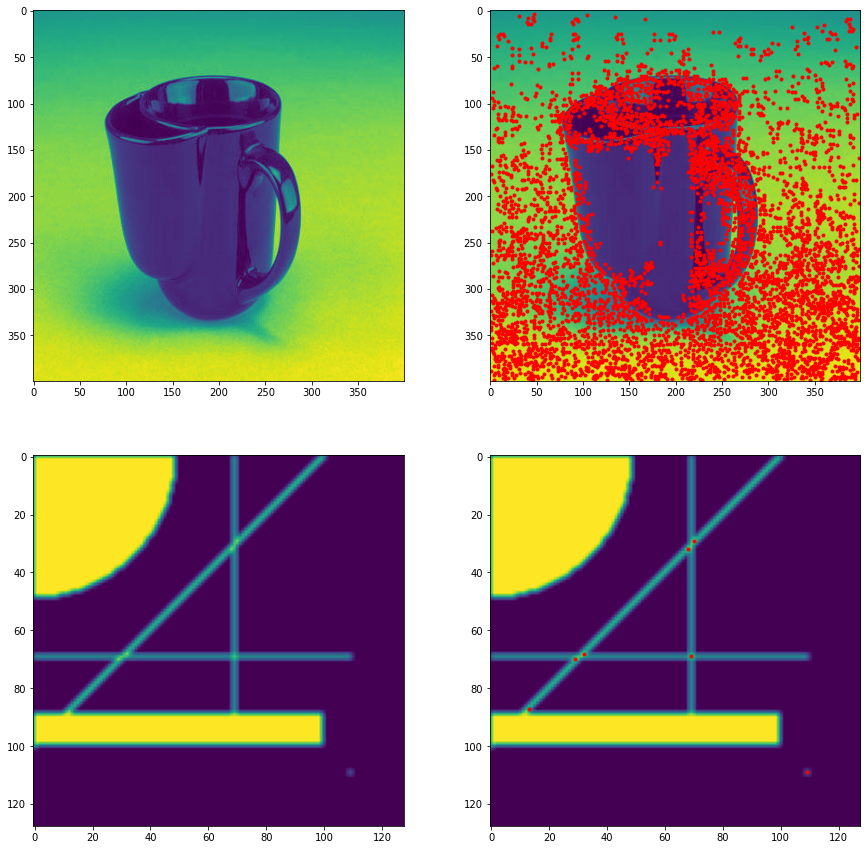

In [ ]:
# define alpha
alpha = 1

# load images
sample_image = load_image_gray("/content/cs4250/data/exercise_3/ueb332.jpg")
sample_np = np.load("/content/cs4250/data/exercise_3/ueb331.npy")

# extract keypoints
keypoints_K, keypoints_K_minus_H = key_points_structure(sample_image, alpha)
keypoints_K2, keypoints_K_minus_H2 = key_points_structure(sample_np, alpha)

# show found keypoints (K, K_minus_H) for both images

# example
_, ax = plt.subplots(2, 2, figsize=(15, 15))
local_max = find_local_max(keypoints_K)
ax[0][0].imshow(sample_image)
plot_marks(local_max, ax[0][0])

local_max = find_local_max(keypoints_K_minus_H)
ax[0][1].imshow(sample_image)
plot_marks(local_max, ax[0][1])

local_max = find_local_max(keypoints_K2)
ax[1][0].imshow(sample_np)
plot_marks(local_max, ax[1][0])

local_max = find_local_max(keypoints_K_minus_H2)
ax[1][1].imshow(sample_np)
plot_marks(local_max, ax[1][1])